# L-Dopa Subchallenge 2 
## Use deep networks to predict symptoms


In [31]:
import pandas as pd
import json
import numpy as np
import pickle #to save files

from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.metrics import precision_score, recall_score,f1_score

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

import nolds
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.core.debugger import Tracer
import synapseclient
syn=synapseclient.login()

Welcome, Luca Lonini!



## Helper fcns

In [3]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur']#,'Sen_X','Sen_Y','Sen_Z','Sen_FFTX','Sen_FFTY','Sen_FFTZ']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
    
    #jerk moments on magnitude
    jerk = rawdata.iloc[:,-1].diff().values
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total
    
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
    sH_raw = []; sH_fft = []
    #on magnitude
#     x = rawdata.iloc[:,-1]
#     n = len(x) #number of samples in clip
#     Fs = np.mean(1/(np.diff(x.timestamp))) #sampling rate in clip
#     sH_raw=nolds.sampen(x) #samp entr raw magnitude
#     f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#     sH_fft=(nolds.sampen(Pxx_den)) #samp entr fft
    #Sample entropy on each axis
#     for a in range(3):
#         x = rawdata.iloc[:,a]
#         n = len(x) #number of samples in clip
#         Fs = np.mean(1/(np.diff(rawdata_wtime.timestamp))) #sampling rate in clip
#         sH_raw.append(nolds.sampen(x)) #samp entr raw data
#         f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#         sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list


#EXTRACT DATA WINDOWS FROM RAW DATA RECORDINGS
def gen_clips(rawdata,clipsize=5,overlap=0,interp=False):
    
    len_tol = 0.8   #% of the intended clipsize below which clip is not used (deprecated for now)

    #reindex time (relative to start)
    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    #create clips data
    deltat = np.median(np.diff(rawdata.timestamp))
    idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
    clips = []
    
    for i in idx:
        c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
        if interp:
            num = 50*clipsize #number of samples to enforce in resampled clip (assume 50 Hz sampling rate)
            if len(c) == num:
                clips.append(c)

            #resample clip if not enough samples are there
            elif (len(c) >len_tol*num) & (len(c)<num): #resample if enough data in clip (200 points for 5 sec clips)
                t = c.timestamp.values
                tnew = np.linspace(0,clipsize,num)
                x_res = resample(c.iloc[:,1].values,num,t)[0]
                y_res = resample(c.iloc[:,2].values,num,t)[0]
                z_res = resample(c.iloc[:,3].values,num,t)[0]
                mag_res = resample(c.iloc[:,4].values,num,t)[0]
                cres = pd.DataFrame(data=np.vstack((tnew,x_res,y_res,z_res,mag_res)).T,columns=list(c.columns))
                clips.append(cres)
                
        else:
            if len(c) > 10: #at least n data points in clip
                clips.append(c)
#         if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
    return clips


    
#PSD on magnitude using Welch method
def power_spectra_welch(rawdata,fm,fM):
    x = rawdata.iloc[:,-1]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (f<=fM)&(f>=fm)
    f=f[inds]
    Pxx_den=Pxx_den[inds]
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])

    return Pxxdf

    
#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
def filter_signal(rawdata,cutoff=0.75,ftype='highpass',order=4):

    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    x = rawdata.iloc[:,1:].values
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate    
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
    b,a = butter(order,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    t = np.expand_dims(t,axis=1)
    rawdatafilt = pd.DataFrame(data=np.hstack((t,xfilt)),columns=rawdata.columns)
    return rawdatafilt

#PERFORMS LEAVE ONE SUBJECT OUT CROSS VALIDATION TO EVALUATE PERFORMANCE OF MODELS AND STORE OUTPUT POSTERIOR 
#PROBABILITIES OF CLASSIFIERS TO BE USED AS FEATURES
#X,y are numpy arrays with features and target
#Fnew is dataframe storing the posteriors (new features)
#returns mean feature importance
def LOSOCV(X,y,groups,models,Fnew):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for clf,model_name in models:

        Prec_all=[]; Rec_all=[]; f1_train=[]; Posteriors=[] 

        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte) #posterior scores on left out subject
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            f1_train.append(f1_score(ytr,ypred_train))

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Prec = precision_score(yte,ypred)
                Rec = recall_score(yte,ypred)
            else:
                print('no positive examples for current test subj')
                Sens = np.nan
            Prec_all.append(Prec); Rec_all.append(Rec)

            #store posteriors from current classifier and subject
#             Fnew[model_name].iloc[test_index]=yscore
            Fnew.loc[test_index,model_name]=yscore

            
        #mean across all subjects
        print(('%s, mean F1 on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(f1_train),2*np.nanstd(f1_train)/np.sqrt(len(f1_train))))
        print(('%s, mean Prec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Prec_all),2*np.nanstd(Prec_all)/np.sqrt(len(Prec_all))))
        print(('%s, mean Rec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Rec_all),2*np.nanstd(Rec_all)/np.sqrt(len(Rec_all))))

    return Fnew


#train classifiers on input training features Xtr and target ytr; 
#returns posterior predictions Fnew from each clf on test data X
def testdata_stacking(Xtr,ytr,Xte,models,Fnew):

    #train multiple classifiers
    for clf,model_name in models:
        print('Training %s'%model_name)
        clf.fit(Xtr,ytr)
        print('Computing prediction %s'%model_name)
        yscore = clf.predict_proba(Xte) #posterior scores on test data
        yscore = yscore[:,1]
        #store posteriors from current classifier on test data
        Fnew.loc[:,model_name]=yscore

    return Fnew

## Load data for a specific symptom 

In [4]:
# symptom_score = 'tremorScore'
symptom_score = 'bradykinesiaScore'
# symptom_score = 'dyskinesiaScore'

In [5]:
#load dataframes and numeric metadata (including normalized recording duration)
df_train = pd.read_csv('./Dataframes/df_train_brady.csv')
# df_test = pd.read_csv('./Dataframes/df_test_brady.csv')
metadata_train = pd.read_csv('metadfnum_train_brady.csv')

In [6]:
df_train.head()

,Unnamed: 0,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
0,25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...
1,25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...
2,25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...
3,25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...
4,25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...


In [7]:
metadata_train.head(3)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
0,17286028,0,2,1,0,0,1,1,1.022774
1,17286030,1,2,1,0,0,1,0,1.022774
2,17286034,0,2,1,0,1,1,1,6.714734


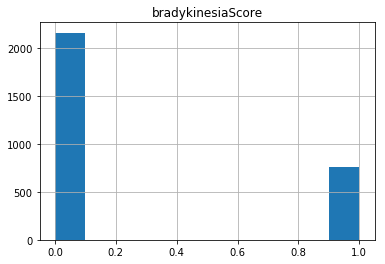

In [8]:
df_train[str(symptom_score)].hist()
plt.title(symptom_score)

In [9]:
len(df_train)

2913

### Plot a recording

Unnamed: 0                                                    25819_22
dataFileHandleId                                              17286028
device                                                       GENEActiv
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             drnkg
visit                                                                1
deviceSide                                                       Right
tremorScore                                                          1
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/28/17286028...
Name: 0, dtype: object
50.0000476838


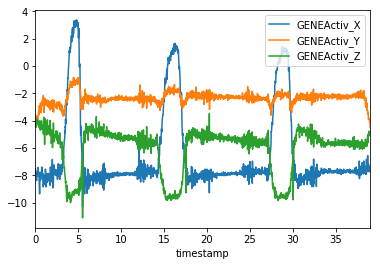

In [9]:
#plot task
idx=0
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata = rawdata.astype('float64') #make sure everything is float
#reindex timestamp data relative to start 
t = rawdata.timestamp
t = t-t.iloc[0]
rawdata.timestamp = t
rawdata=rawdata.drop(rawdata.columns[-1],axis=1) #don't plot acc magnitude
# rawdata = filter_signal(rawdata,order=2) #hp filter data
ax = rawdata.plot(x='timestamp')
deltat = np.median(np.diff(rawdata.timestamp)) #1/Fs
print(1/deltat)

In [10]:
#compute clips and plot
#create clips data
clipsize=5
overlap=0.5
interp=True
deltat = np.median(np.diff(rawdata.timestamp))
idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
clips = []

for i in idx:
    c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
    num = 50*clipsize #number of samples to enforce in resampled clip (assume 50 Hz sampling rate)
    if len(c) == num:
        clips.append(c)

In [11]:
clips = gen_clips(rawdata,interp=True)

In [12]:
clips[2].head()

,timestamp,GENEActiv_X,GENEActiv_Y,GENEActiv_Z
500,10.00,-7.90608,-2.43366,-5.24381
501,10.02,-8.02354,-2.43468,-5.24459
502,10.04,-7.98492,-2.16059,-5.32216
503,10.06,-7.90610,-2.35489,-5.16845
504,10.08,-7.98433,-2.39511,-5.16805


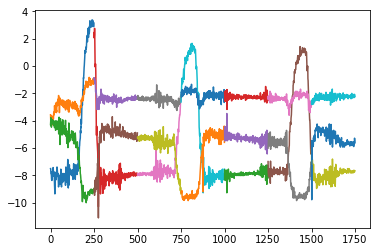

In [13]:
for i in range(len(clips)):
    plt.plot(clips[i].iloc[:,1:])

In [14]:
#plot resampled data
num = 50*len(rawdata)
rawdata = rawdata.astype('float64') #make sure everything is float
rawdata_res = rawdata.copy()
t = rawdata_res.timestamp.values
x_res = resample(rawdata_res[~rawdata_res.iloc[:,1].isnull()].iloc[:,1].values,num,t)[0]
y_res = resample(rawdata_res[~rawdata_res.iloc[:,2].isnull()].iloc[:,1].values,num,t)[0]
z_res = resample(rawdata_res[~rawdata_res.iloc[:,3].isnull()].iloc[:,1].values,num,t)[0]

In [15]:
len(rawdata)

1950

## Prepare data to be fed to a NN

In [10]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_MLP(model,num1,drop1,num2,drop2):
    model.add(Dense(num1, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(drop1))
    model.add(Dense(num2, activation='relu'))
    model.add(Dropout(drop2))

### Generate and save data clips to train network

In [231]:
#gen raw data clips and store them in format (clip,time,channel)
row = 0
nans_found=0; n_empty=0
max_nans = []
ind_nan = [] #the indices of the clips with nans
t1 = time.time()
data = [] #store extracted clips
targetscore = [] #store target score
subj = [] #store subj for CV 
task = [] #store task

X_meta = metadata_train

for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        ind_nan.append(i) #store the index of the clip with nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans
        
    #attempt extracting clips if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
#         rawdata = filter_signal(rawdata,order=2)

        #extract and concatenate clips data
        clips = gen_clips(rawdata,overlap=0,interp=True) #take clips over recording
        for clip in clips:
            datac = np.expand_dims(clip.iloc[:,1:4].values,axis=0) #convert to format (nclip,time,channel)
            data.append(datac)
            targetscore.append(df_train.iloc[i][symptom_score]) #the score for the current clip
            subj.append(X_meta.iloc[i].patient)
            task.append(X_meta.iloc[i].task)
#             data=np.concatenate((data,datac),axis=0)
            
    else:
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
Elapsed Time:[s] 56.1
Files w nans: 87
Files w 0 non-nan rows 0
Tot rows: 2913


In [233]:
features = np.asarray(data).squeeze()

In [234]:
features.shape

(14403, 250, 3)

In [235]:
CNN_clips = {'X':features,'y':np.asarray(targetscore),'Subj':subj,'Task':task}

In [236]:
CNN_clips['X'].shape

(14403, 250, 3)

In [237]:
#save clips
filename = 'CNNclips_train_bradyk.pkl'
f = open(filename,'wb')
pickle.dump(CNN_clips,f)
f.close()

### Load data clips and train network

In [11]:
#load clips
filename = 'CNNclips_train_bradyk.pkl'
f = open(filename, 'rb')
CNN_clips = pickle.load(f)
f.close()

In [12]:
X = CNN_clips['X']
y = CNN_clips['y']
groups = np.asarray(CNN_clips['Subj'])
task = np.asarray(CNN_clips['Task'])

In [226]:
#select specific task
# ind = (task>1) & (task < 6) #finger to nose
# X = X[ind,:,:]
# y = y[ind]

In [13]:
X.shape

(14403, 250, 3)

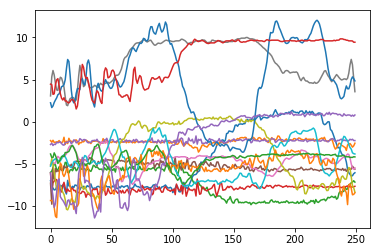

In [14]:
#plot some clips
for i in range(5,10):
    plt.plot(X[i])

[ 0.27923951  0.31949438  0.25787512] [ 1.39561366  1.85358287  0.91729482]
[ 0.35930962  0.29519793  0.44209706] [ 1.79579679  1.71262427  1.57259585]
[ 0.39921491  0.29682501  0.3059431 ] [ 1.99523975  1.72206395  1.08827877]
[ 0.34658671  0.27550926  0.24232629] [ 1.73220884  1.59839821  0.86198562]
[ 0.44857582  0.2707593   0.30291296] [ 2.2419411   1.57084075  1.07750018]


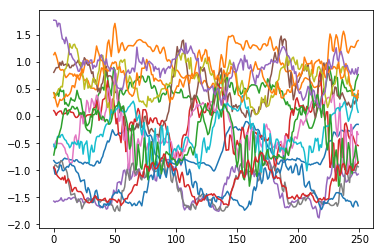

In [214]:
#standardize clips data by channel (for CNN)
Xn = X.copy()
acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
m = np.mean(acc,axis=0)
s = np.std(acc,axis=0)
for c in range(X.shape[0]):
    for a in range(X.shape[2]):
        Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
Xn.shape
for i in range(5,10):
    print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
    plt.plot(Xn[i])

[  954   955  2730  2839  4862  4927  4989  5308  7103  7103  8488  9240
  9240  9408  9408  9566  9623  9908  9979 10032 13454 13940 13959]


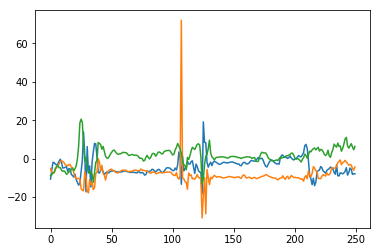

In [460]:
#note that some clips have spikes in the acceleration (errors) that should be fixed
indmax = np.where(np.abs(X>40))[0]
# for i in indmax:
#     x=X[i].copy()
#     vals = x[(x>40) | (x<-40)]
#     newvals = nps
print(indmax)
plt.plot(X[indmax[3]])

In [321]:
# #standardize data (mean 0, std 1)
# Xscaler = StandardScaler()

# for s in np.unique(groups):
#     ind = groups==s
#     for a in range(3):        
#         X[ind,:,a]= Xscaler.fit_transform(X[ind,:,a])

In [16]:
#perform a random train_valid split first to test approach
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.33,random_state=32)
X_train.shape

(9650, 250, 3)

In [17]:
num_classes = 2 # 
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

In [18]:
#specifying hyper-parameters
batch_size = 256 #1024
feat_map_num = 16
_, win_len, dim = X.shape
# network_type = 'CNN'
network_type = 'MLP'

In [19]:
print('reshaping data for different models ...')
X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
X_train.shape

reshaping data for different models ...
MLP


(9650, 750)

In [22]:
#normalize input train data
Xscaler = StandardScaler()
Xn_train = X_train.copy()
Xn_train = Xscaler.fit_transform(X_train)

In [29]:
Xn_valid = X_valid.copy()
Xn_valid = Xscaler.transform(X_valid)

In [30]:
print('building the model ...')
model = Sequential()
if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model)
    model_variant(model, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP':
    model_MLP(model,64,0.1,16,0.1)
model.add(Dense(num_classes, activation='softmax'))
model.summary()


building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                48064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 49,138
Trainable params: 49,138
Non-trainable params: 0
_________________________________________________________________


In [32]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 9650 samples, validate on 4753 samples
Epoch 1/20
9650/9650 [==============================] - 0s - loss: 1.4796 - acc: 0.6774 - val_loss: 0.6495 - val_acc: 0.7766
Epoch 2/20
9650/9650 [==============================] - 0s - loss: 0.6682 - acc: 0.7533 - val_loss: 0.5665 - val_acc: 0.7785
Epoch 3/20
9650/9650 [==============================] - 0s - loss: 0.5725 - acc: 0.7772 - val_loss: 0.5318 - val_acc: 0.7835
Epoch 4/20
9650/9650 [==============================] - 0s - loss: 0.5385 - acc: 0.7890 - val_loss: 0.5237 - val_acc: 0.7837
Epoch 5/20
9650/9650 [==============================] - 0s - loss: 0.5219 - acc: 0.7905 - val_loss: 0.5127 - val_acc: 0.7835
Epoch 6/20
9650/9650 [==============================] - 0s - loss: 0.5101 - acc: 0.7937 - val_loss: 0.5159 - val_acc: 0.7833
Epoch 7/20
9650/9650 [==============================] - 0s - loss: 0.4976 - acc: 0.8002 - val_loss: 0.5088 - val_acc: 0.7856
Epoch 8/20
9650/9650 [==============================] - 0s

calculating confusion matrix ... 
[[3614   76]
 [ 907  156]]
the mean f1 score:0.56


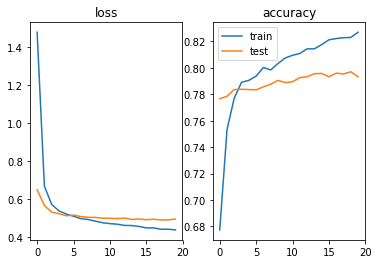

In [33]:
fig=plt.figure()
fig.add_subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
fig.add_subplot(122)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('accuracy')
plt.legend(['train','test'],loc='best')

#performance eval
y_pred = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)
print('calculating confusion matrix ... ')
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))


In [44]:
len(model.get_weights())

6

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                48064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 49,138
Trainable params: 49,138
Non-trainable params: 0
_________________________________________________________________


In [62]:
l1 = model.layers[0]
l1.activation

<function keras.activations.relu>

In [45]:
W = model.get_weights()
for w in W:
    print(w.shape)

(750, 64)
(64,)
(64, 16)
(16,)
(16, 2)
(2,)


(array([  155.,  2980.,  7288.,  7822.,  7813.,  7706.,  7703.,  5636.,
          871.,    26.]),
 array([-0.12889788, -0.10154927, -0.07420066, -0.04685205, -0.01950344,
         0.00784516,  0.03519377,  0.06254238,  0.08989099,  0.11723959,
         0.1445882 ]),
 <a list of 10 Patch objects>)

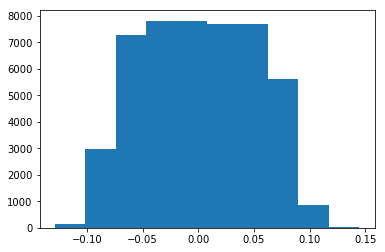

In [55]:
w0 = W[0]
ax = plt.hist(np.reshape(w0,(w0.shape[0]*w0.shape[1])))

## Train task-specific model

In [84]:
task=np.asarray(CNN_clips['Task'])

In [90]:
le = preprocessing.LabelEncoder()
tasknum = le.fit_transform(df_train.task)
tasknum = np.unique(tasknum)
taskc = le.inverse_transform(tasknum)
print(tasknum,taskc)

[ 0  1  2  3  4  5  6  7  8  9 10] ['drnkg' 'fldng' 'ftnl1' 'ftnl2' 'ftnr1' 'ftnr2' 'orgpa' 'raml1' 'raml2'
 'ramr1' 'ramr2']


In [85]:
np.unique(task)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

14403